# IS460-G2 Machine Learning & Applications

## Project Topic: Classification and Prediction of Pneumonia from Chest X-Ray Images

### CNN Model_Improved  
  
  In this Notebook, we attempt to improve the current CNN Model built using Pre-Trained Models.  
  In particular we make use of "ResNet" and "InceptionV3", that are pre-trained CNN Models available.  
  - Residulal Network (ResNet) is a type of CNN Deep Learning Architecture specifically designed for very deep neural networks. We attempt to use ResNet for our Chest X-Ray Image Classification to harness its known effectiveness in training very deep networks, and higher benefits in working with complex and large datasets  
  
- InceptionV3 offers an alternative approach to deep learning. It introduces the concept of inception modules, which use parallel convolutional filters of different sizes to capture features at various scales. InceptionV3 is designed to be computationally efficient and is particularly valuable when computational resources are limited. It can efficiently capture diverse features and has proven to be a strong performer in various computer vision tasks.

#### Group 7: Shaun, Shan Mei, Xiao Xiao, Xiao Fang, Matthew, Tun Hao
 
 Following the Severe Pneumonia clusters that raised questions on accuracy and precision of pneumonia diagnosis during the COVID pandemic, this project aims to accurately identify and diagnose pneumonia patients through image classification and explore other methods of building machine learning algorithms to solve the problem.
 
(https://www.straitstimes.com/singapore/health/all-pneumonia-patients-in-public-hospitals-here-being-tested-for-coronavirus-moh) 

In [91]:
pip install --upgrade tensorflow

                                              0.0/284.2 MB ? eta -:--:--
                                             0.8/284.2 MB 16.1 MB/s eta 0:00:18
                                             1.4/284.2 MB 17.3 MB/s eta 0:00:17
                                             1.9/284.2 MB 15.3 MB/s eta 0:00:19
                                             2.3/284.2 MB 12.5 MB/s eta 0:00:23
                                             2.7/284.2 MB 11.7 MB/s eta 0:00:25
                                             3.2/284.2 MB 11.9 MB/s eta 0:00:24
                                             3.6/284.2 MB 10.9 MB/s eta 0:00:26
                                             4.1/284.2 MB 11.3 MB/s eta 0:00:25
                                             4.5/284.2 MB 11.0 MB/s eta 0:00:26
                                             4.9/284.2 MB 10.9 MB/s eta 0:00:26
                                             5.4/284.2 MB 10.8 MB/s eta 0:00:26
                                             5.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\fasci\\anaconda3\\Lib\\site-packages\\~ensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



### Import Packages

In [121]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Input, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score

### Import Dataset



In [6]:
path = "chest_xray"
folders = ['train','test','val']

pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,test
1,train
2,val
3,__MACOSX


In [11]:
def load_data(folder_path, img_size=(150, 150)):
    images = []
    labels = []
    class_names = os.listdir(folder_path) 
    for class_name in class_names:
        class_folder_path = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels)

# Load training data
x_train, y_train = load_data(os.path.join(path, 'train'))

In [18]:
# View Image Count in Folders
dict_={'train':[],'test':[],'val':[]}
class_names = []
for i in tqdm(folders):
    path_ = os.path.join(path, i)
    
    for j in os.listdir(path_):
        if i == 'train':  # Only append class names once, assuming 'train' contains all classes
            class_names.append(j)
        dict_[i].append(len(os.listdir(os.path.join(path_, j))))

df = pd.DataFrame(dict_, index=class_names)
print(df)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 95.85it/s]

           train  test  val
NORMAL      1341   234    8
PNEUMONIA   3875   390    8


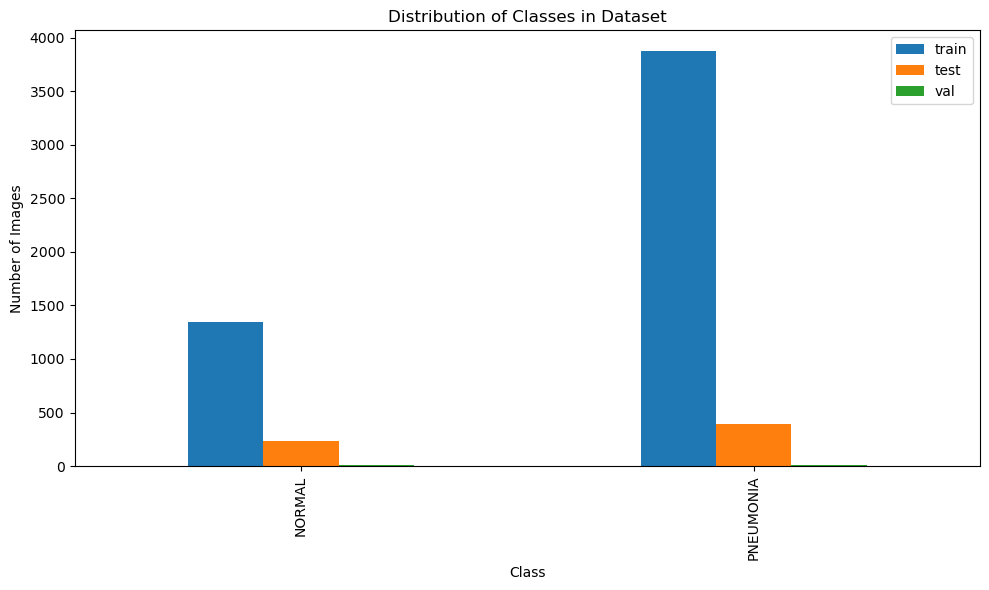

In [19]:
# Plotting the distribution
df.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [20]:
# Define Function to Identify Image Sizes
def Size(folder):
    size=[]
    path_=os.path.join(path,folder)
    for i in tqdm(os.listdir(path_)):
        path2=os.path.join(path_,i)
        for j in os.listdir(path2):
            img=cv2.imread(os.path.join(path2,j))
            size.append(img.shape)
    return pd.Series(size)

In [21]:
# View Image Sizes in Each Folder
print("Size of train: ", Size('train')); print("Size of test: ", Size('test')); print("Size of val: ",Size('val'))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:52<00:00, 26.03s/it]


Size of train:  0       (1858, 2090, 3)
1       (1152, 1422, 3)
2       (1434, 1810, 3)
3       (1279, 1618, 3)
4       (1125, 1600, 3)
             ...       
5211     (882, 1414, 3)
5212     (696, 1256, 3)
5213     (856, 1152, 3)
5214     (728, 1248, 3)
5215     (784, 1176, 3)
Length: 5216, dtype: object


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]


Size of test:  0      (1317, 1857, 3)
1      (1509, 2111, 3)
2      (1837, 2031, 3)
3      (1326, 1663, 3)
4      (1818, 2053, 3)
            ...       
619     (856, 1120, 3)
620     (856, 1064, 3)
621    (1024, 1400, 3)
622    (1016, 1264, 3)
623    (1122, 1704, 3)
Length: 624, dtype: object


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]

Size of val:  0     (1416, 1776, 3)
1     (1040, 1272, 3)
2     (1416, 1736, 3)
3      (928, 1288, 3)
4     (1104, 1240, 3)
5     (1104, 1328, 3)
6     (1225, 1632, 3)
7     (1302, 1564, 3)
8       (592, 968, 3)
9      (712, 1072, 3)
10     (664, 1152, 3)
11     (944, 1416, 3)
12     (864, 1256, 3)
13     (656, 1016, 3)
14     (952, 1192, 3)
15    (1128, 1664, 3)
dtype: object


# Data Preprocessing and Augmentation


Data augmentation techniques used in Image Classification includes rescaling the images to normalize the dataset, random rotations, flipping and zooming applied to the training dataset to increase diversity of training samples

In [35]:
# Create Function that includes all Preprocessing and Augmentation required
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to the range [0, 1] -> Normalization
    rotation_range=20,   # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,     # Shear transformation
    zoom_range=0.1,      # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'  # Fill in missing pixels using the nearest value
)


Data augmentation is primarily applied to the training dataset to artificially increase the diversity of the training samples.    

It helps the model generalize better by exposing it to various transformations, such as rotation, flipping, and zooming. These augmentations aim to simulate real-world variations and introduce robustness to the model. However, **we do not apply the same augmentation to the test and validation sets** to simulate the real-world scenarios where images are unaltered.

In [26]:
# preprocess the validation and test datasets, respectively, by rescaling the pixel values to a normalized range. 

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

### Load Augmentation to Images  
We will load and preprocess the data using a pre-defined function so that the code can run on without any edits to a personal folder path. Dataset should be in same zip file appended with jupyter notebook.

Conduct Augmentation using pre-defined function.

In [56]:
# Load Data Using ImageDataGenerator

train_generator = datagen.flow_from_directory(
    './chest_xray/train',  # Path to the training data directory
    target_size=(224, 224),  # Target image size
    batch_size=32,
    class_mode='binary'  # 'binary' for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    './chest_xray/val',  # Path to the validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    './chest_xray/test',  # Path to the test data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [57]:
# Check class labels
class_labels = train_generator.class_indices
print(class_labels)

# Check the number of samples in each dataset
num_train_samples = train_generator.samples
num_val_samples = validation_generator.samples
num_test_samples = test_generator.samples

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")


{'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


In [58]:
# Check the shapes and other properties of your data
print("X_train shape:", train_generator.image_shape)
print("Number of training samples:", train_generator.samples)

print("X_val shape:", validation_generator.image_shape)
print("Number of validation samples:", validation_generator.samples)


X_train shape: (224, 224, 3)
Number of training samples: 5216
X_val shape: (224, 224, 3)
Number of validation samples: 16


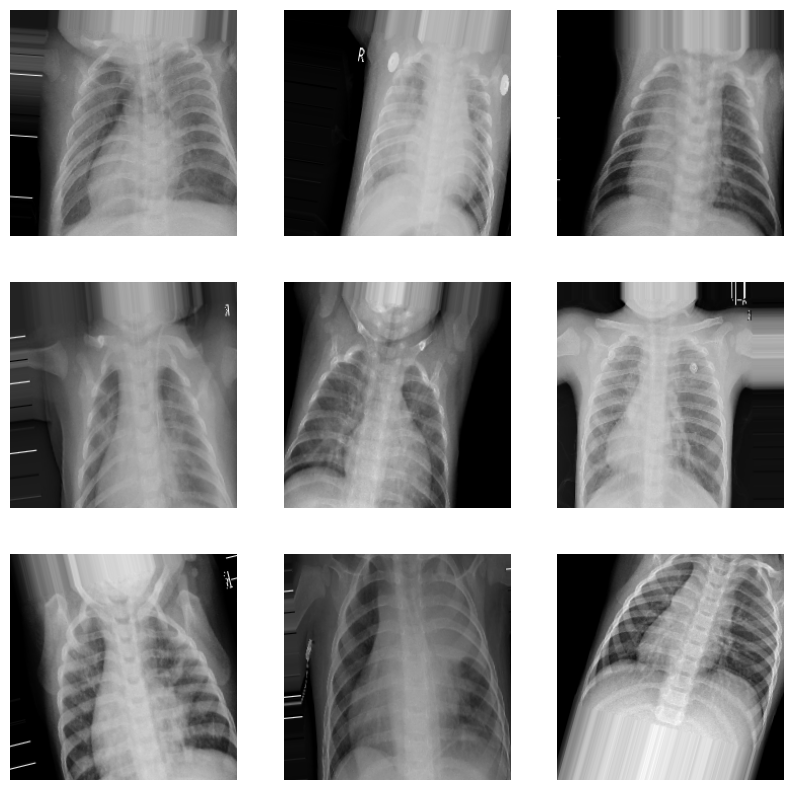

In [59]:
# Visualize augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image, _ = train_generator.next()
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.show()


# Using ResNet in this CNN Architecture

### Shortfall in our Earlier CNN Architecture  
  
Our previous CNN Architecture had several component such as Convolutional layers, MaxPooling layers, Dense layers, regularization. While this architecture was effective for image classification tasks (relative to our regression based models), there may have been shortfalls:  
- Shallow Structure  
- Dataset was too Complex and needs deeper learning  
- Lack of Pretrained Features  

### Loading the Pre-Trained ResNet Model  

1) Load the ResNet-50 model with pre-trained weights and exclude the top (classification) layers by setting include_top=False. This base model can extract high-level features from images.  
  
  
2) We freeze the layers of the pre-trained model using a loop. Freezing these layers means they won't be updated during training, which is often a good practice when using pre-trained models.  
  
  
3) We add custom classification layers on top of the pre-trained ResNet-50 - Global Average Pooling (GAP) to reduce the spatial dimensions, a Dense layer with 128 units, a Dropout layer to prevent overfitting, and a final Dense layer with a single unit and a sigmoid activation for binary classification.  
  
  
4) We create the final model using Model, specifying the input as the input of the base model and the output as our custom classification layers.  
  
  
5) We compile the model, specifying the optimizer (e.g., Adam), loss function (binary cross-entropy for binary classification), and metrics (e.g., accuracy).  
  
  ResNet-50 itself uses L2 regularization in its convolutional layers for weight regularization

In [93]:
# Load the ResNet-50 model with pre-trained weights and exclude the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom classification layers with L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.2)(x)  # You can adjust the dropout rate
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
# Summary of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

### Loading the Pre-Trained InceptionV3 Model  

InceptionV3, also known as GoogLeNet, is characterized by the use of inception modules. These modules incorporate parallel convolutional filters of different sizes to capture features at various scales. It promotes feature diversification. InceptionV3 is designed to be computationally efficient and has a relatively small number of parameters compared to deeper networks like ResNet. This efficiency is particularly beneficial for scenarios with limited computational resources.

It also has a more complex architecture due to its use of inception modules. It's relatively deeper compared to traditional architectures like LeNet and VGGNet.

The inception modules enable parallel processing of features at different scales, which can improve the network's ability to recognize complex patterns.

In [98]:
# Load the InceptionV3 model with pre-trained weights and exclude the top (classification) layers
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model_inception.layers:
    layer.trainable = False

# Add your custom classification layers with L2 regularization
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.2)(x)  # You can adjust the dropout rate
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model_inception = Model(inputs=base_model_inception.input, outputs=predictions)

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 5s 0us/step


In [100]:
# Summary of model_inception
model_inception.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

# Train the ResNet Model

Epoch => Specify the number of iterations over the entire dataset. During each epoch, the entire training dataset is processed once by the model.

loss => training loss for the current epoch. It represents how well the model is fitting the training data.

accuracy => This is the training accuracy for the current epoch. It represents the proportion of correctly predicted samples in the training data.

val_loss => This is the validation loss for the current epoch. It measures how well the model is performing on a separate validation dataset that it hasn't seen during training.

val_accuracy => This is the validation accuracy for the current epoch. It represents the proportion of correctly predicted samples in the validation dataset.

In [95]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)


# Example usage during model training
# Train the model with the updated hyperparameters
history = model.fit(
    train_generator,
    epochs=8,
    batch_size = 64,
    validation_data=  validation_generator,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)


Epoch 1/8
163/163 [==============================] - 205s 1s/step - loss: 0.8443 - accuracy: 0.7418 - val_loss: 1.0029 - val_accuracy: 0.5000
Epoch 2/8
163/163 [==============================] - 219s 1s/step - loss: 0.5761 - accuracy: 0.7429 - val_loss: 0.8446 - val_accuracy: 0.5000
Epoch 3/8
163/163 [==============================] - 215s 1s/step - loss: 0.5588 - accuracy: 0.7427 - val_loss: 0.8136 - val_accuracy: 0.5000
Epoch 4/8
163/163 [==============================] - 220s 1s/step - loss: 0.5491 - accuracy: 0.7433 - val_loss: 0.9576 - val_accuracy: 0.5000
Epoch 5/8
163/163 [==============================] - 217s 1s/step - loss: 0.5393 - accuracy: 0.7431 - val_loss: 0.7225 - val_accuracy: 0.5000
Epoch 6/8
163/163 [==============================] - 213s 1s/step - loss: 0.5320 - accuracy: 0.7506 - val_loss: 0.6782 - val_accuracy: 0.5625
Epoch 7/8
163/163 [==============================] - 218s 1s/step - loss: 0.5306 - accuracy: 0.7471 - val_loss: 0.8337 - val_accuracy: 0.5000
Epoch 

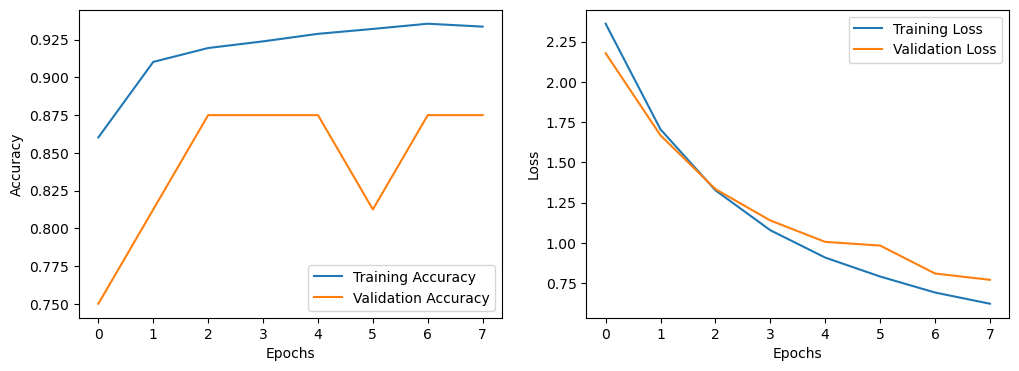

In [102]:
# Visualize training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Train the InceptionV3 Model

Epoch => Specify the number of iterations over the entire dataset. During each epoch, the entire training dataset is processed once by the model.

loss => training loss for the current epoch. It represents how well the model is fitting the training data.

accuracy => This is the training accuracy for the current epoch. It represents the proportion of correctly predicted samples in the training data.

val_loss => This is the validation loss for the current epoch. It measures how well the model is performing on a separate validation dataset that it hasn't seen during training.

val_accuracy => This is the validation accuracy for the current epoch. It represents the proportion of correctly predicted samples in the validation dataset.

In [101]:
# Train the model with the updated hyperparameters
history = model_inception.fit(
    train_generator,
    epochs=8,
    batch_size = 64,
    validation_data=  validation_generator,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

Epoch 1/8
163/163 [==============================] - 141s 850ms/step - loss: 2.3611 - accuracy: 0.8602 - val_loss: 2.1776 - val_accuracy: 0.7500
Epoch 2/8
163/163 [==============================] - 153s 936ms/step - loss: 1.7044 - accuracy: 0.9103 - val_loss: 1.6672 - val_accuracy: 0.8125
Epoch 3/8
163/163 [==============================] - 145s 887ms/step - loss: 1.3261 - accuracy: 0.9195 - val_loss: 1.3336 - val_accuracy: 0.8750
Epoch 4/8
163/163 [==============================] - 147s 898ms/step - loss: 1.0781 - accuracy: 0.9239 - val_loss: 1.1386 - val_accuracy: 0.8750
Epoch 5/8
163/163 [==============================] - 145s 891ms/step - loss: 0.9080 - accuracy: 0.9289 - val_loss: 1.0057 - val_accuracy: 0.8750
Epoch 6/8
163/163 [==============================] - 148s 910ms/step - loss: 0.7905 - accuracy: 0.9321 - val_loss: 0.9828 - val_accuracy: 0.8125
Epoch 7/8
163/163 [==============================] - 154s 942ms/step - loss: 0.6911 - accuracy: 0.9356 - val_loss: 0.8093 - val_ac

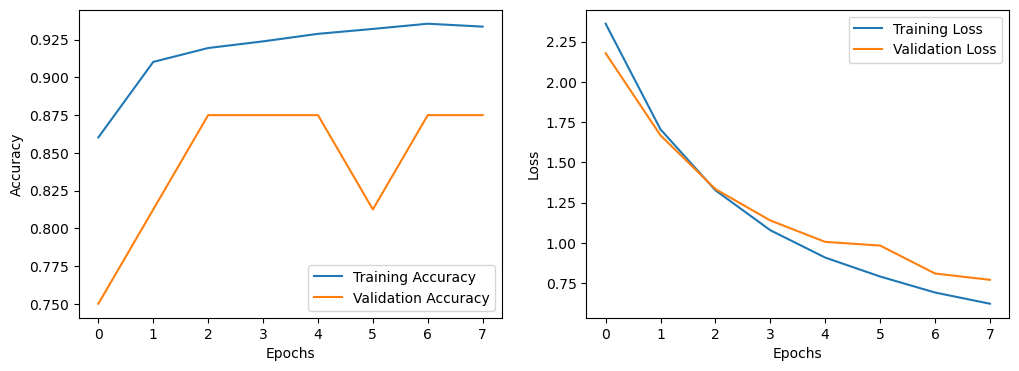

In [104]:
# Visualize training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluating the InceptionV3 Model on train set  
  
  As the InceptionV3 models proved to predict the dataset more accurately with better final epoch accuracy scores (InceptionV3 Accuracy of 0.934, ResNet Accuracy of 0.7490), we decided to move ahead with the InceptionV3 Architecture as the final model on the Training, Validation and Test Set.

163/163 [==============================] - 137s 837ms/step


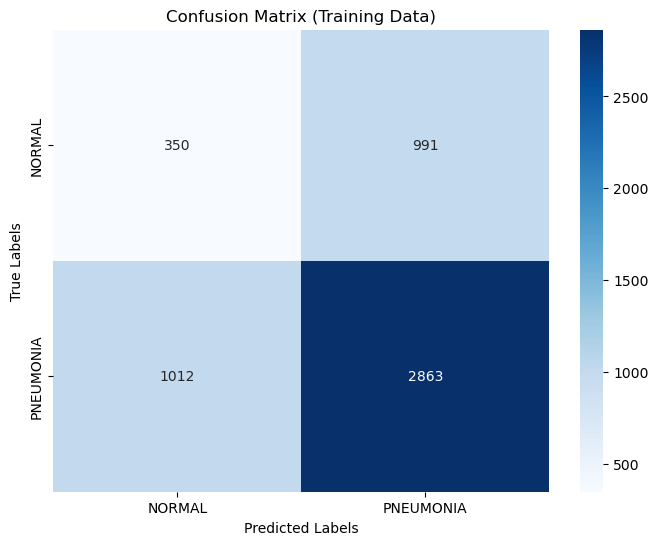

Accuracy: 0.6160
Precision: 0.7429
Recall: 0.7388
F1-Score: 0.7408


In [103]:
# Generate predictions on the training data
y_pred_probabilities = model_inception.predict(train_generator)

# Convert probabilities to binary classes (assuming threshold of 0.5)
y_pred_binary = (y_pred_probabilities > 0.5).astype(int)

# Get the true labels for the training data
y_true = train_generator.classes

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred_binary)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Data)')
plt.show()

# Calculate metrics
TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_value = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_value:.4f}")

# Evaluating model on test set


In [105]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_inception.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}")

20/20 [==============================] - 11s 530ms/step - loss: 0.8097 - accuracy: 0.8173
Test accuracy: 0.82


# To evaluate your model using a confusion matrix with a test generator

True Positives (TP): These are cases where your model correctly predicted that the condition (pneumonia) is present. In your case, the model correctly predicted pneumonia in 362 images.

False Positives (FP): These are cases where your model incorrectly predicted that the condition is present when it's not. In your case, the model made 40 false positive predictions, indicating that it predicted pneumonia when it was not actually present.

True Negatives (TN): These are cases where your model correctly predicted that the condition is not present (normal). In your case, the model correctly predicted normal in 194 images.

False Negatives (FN): These are cases where your model incorrectly predicted that the condition is not present when it is. In your case, the model made 28 false negative predictions, indicating that it failed to detect pneumonia in cases where it was actually present.


In [114]:
# Define a custom data generator for test data
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  # Adjust rescaling as needed

# Load and preprocess test data using the generator
test_generator = test_data_generator.flow_from_directory(
    './chest_xray/test',  # Path to the test data directory
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False,  # Do not shuffle test data
)

# Generate predictions for the test dataset
y_pred = model_inception.predict(test_generator)

# Convert predicted probabilities to class labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)

# Get true labels from the test generator
y_true = test_generator.classes

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

# A    Predicted
# c     +    -
# t  + [TN, FP]
# u
# a  - [FN, TP]
# l

Found 624 images belonging to 2 classes.
10/10 [==============================] - 11s 1s/step
Confusion Matrix:
[[142  92]
 [ 22 368]]


In [115]:
# Assuming you have a confusion matrix in the form of a 2x2 NumPy array
# confusion_matrix = [[TN, FP],
#                     [FN, TP]]

# Calculate metrics
TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1 = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.8173
Precision: 0.8000
Recall: 0.9436
F1-Score: 0.8659


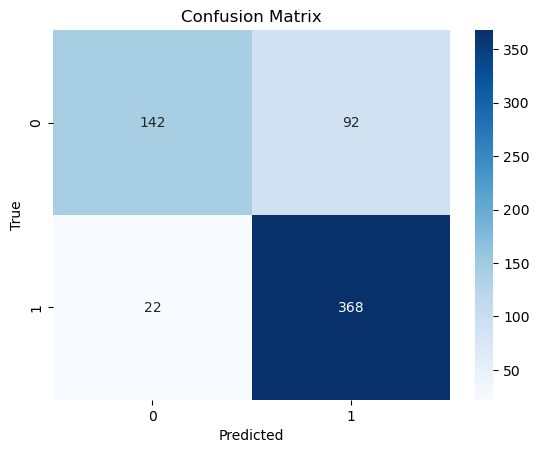

In [116]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

# Create a heatmap
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


10/10 [==============================] - 11s 991ms/step


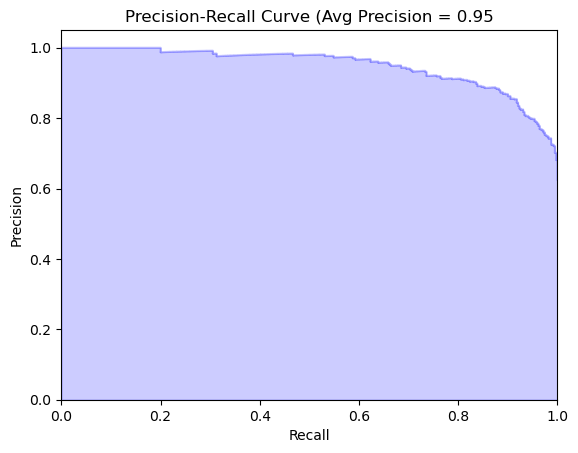

Confusion Matrix:
[[142  92]
 [ 22 368]]
Accuracy: 0.82
Precision (Class 0 - Negative): 0.62
Precision (Class 1 - Positive): 0.63
Recall (Class 0 - Negative): 1.00
Recall (Class 1 - Positive): 1.00
F1 Score: 0.87


In [122]:
# Get the true labels for your test data
y_true = test_generator.classes

# Obtain predictions from your model
y_pred_probabilities = model_inception.predict(test_generator)

# Assuming y_pred_probabilities is a 1D array where y_pred_probabilities represents probabilities of the positive class
# In binary classification, you can also convert probabilities to binary predictions
y_pred_binary = (y_pred_probabilities > 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred_binary)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1_final = f1_score(y_true, y_pred_binary) 

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_true, y_pred_probabilities)
avg_precision = average_precision_score(y_true, y_pred_probabilities)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f}')
plt.show()

# Print evaluation metrics for both classes
print(f'Confusion Matrix:\n{confusion}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision (Class 0 - Negative): {precision[0]:.2f}')
print(f'Precision (Class 1 - Positive): {precision[1]:.2f}')
print(f'Recall (Class 0 - Negative): {recall[0]:.2f}')
print(f'Recall (Class 1 - Positive): {recall[1]:.2f}')
print(f'F1 Score: {f1_final:.2f}')  # Updated variable name

In [123]:
# Save the entire model to a HDF5 file
model_inception.save('my_inception_model.h1')


# Later, when you want to load the model, you can use the load_model function from Keras:
from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('my_CNNmodel.h1')


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: my_inception_model.h1\assets


INFO:tensorflow:Assets written to: my_inception_model.h1\assets
